Based on https://github.com/rapidsai-community/notebooks-contrib/blob/main/community_tutorials_and_guides/weather.ipynb

In [1]:
import cudf
import dask, dask_cudf
import os
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
from dask.diagnostics import ProgressBar
import cuspatial
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import dask.config

# Simpler Multi-GPU ETL using Dask

A major focus of the RAPIDS project is easier scaling: up and out.

The dask-cuda project automatically handles configuring Dask worker processes to make use of available GPUs

The dask-cudf supports a variety of common ETL operations and friendlier parallel IO.

Here we demonstrate just how simple parallel processing is with RAPIDS, and how you can scale your data science work to multiple GPUs with ease.


In [2]:
dask.config.set({'distributed.rmm.pool-size': "30GB"})
dask.config.set({'distributed.ucx.cuda_copy': "True"})
dask.config.set({'distributed.ucx.nvlink': "True"})
dask.config.set({'distributed.ucx.infiniband': "True"})
dask.config.set({'distributed.ucx.net-devices': "ib0"})


In [3]:
os.environ["DASK_LOGGING__DISTRIBUTED"]="info"
os.environ["DASK_DISTRIBUTED__COMM__UCX__CREATE_CUDA_CONTEXT"]="True"
os.environ["DASK_DISTRIBUTED__COMM__UCX__CUDA_COPY"]="True"
os.environ["DASK_DISTRIBUTED__COMM__UCX__TCP"]="True"
os.environ["DASK_DISTRIBUTED__COMM__UCX__NVLINK"]="True"
os.environ["DASK_DISTRIBUTED__COMM__UCX__INFINIBAND"]="True"
os.environ["DASK_DISTRIBUTED__COMM__UCX__RDMACM"]="True"
os.environ["UCX_MEMTYPE_REG_WHOLE_ALLOC_TYPES"]="cuda"
os.environ["UCX_MEMTYPE_CACHE"]="n"

Use dask-cuda to start one worker per GPU on a single-node system

When you shutdown this notebook kernel, the Dask cluster also shuts down.


In [4]:
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES=[0, 1, 2, 3], n_workers=4, threads_per_worker=8, 
                           protocol="ucx", interface="ib0", enable_tcp_over_ucx=True, enable_infiniband=True, 
                           enable_nvlink=True, enable_rdmacm=True, 
                           rmm_pool_size="30GB",)
client = Client(cluster)


2025-07-07 21:58:54,177 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle db69fc4cc9f949f951edb53afc5525a6 initialized by task ('shuffle-transfer-db69fc4cc9f949f951edb53afc5525a6', 25) executed on worker ucx://10.128.7.77:51492
2025-07-07 21:59:02,601 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle db69fc4cc9f949f951edb53afc5525a6 deactivated due to stimulus 'task-finished-1751918342.600614'


print client info

In [5]:
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://10.128.7.77:8787/status,
Dashboard: http://10.128.7.77:8787/status,Workers: 4
Total threads: 32,Total memory: 482.42 GiB
Status: running,Using processes: True
Comm: ucx://10.128.7.77:42088,Workers: 4
Dashboard: http://10.128.7.77:8787/status,Total threads: 32
Started: Just now,Total memory: 482.42 GiB
Comm: ucx://10.128.7.77:42633,Total threads: 8
Dashboard: http://10.128.7.77:43811/status,Memory: 120.61 GiB
Nanny: ucx://10.128.7.77:45198,


Ok, we've got a cluster of GPU workers. 

Notice also the link to the Dask status dashboard.

It provides lots of useful information while running data processing tasks.

On Leonardo compute node we cannot download the dataset

We need to have pre-downloaded data!

Here we assume that data have been already downloaded and the files are in the following directory


In [6]:
data_dir="/leonardo_work/tra25_ictp_rom/DAY8data/weather/data/"

Notice that the CSV files don't have headers, we specify column names manually

In [7]:
names = ["station_id", "date", "type", "val"]

Moreover, there are a lot of features and fields, but only the first 4 are relevant for us

In [8]:
usecols = names[0:4]

Wait... there are many weather files.

To read all these files in, we can simply use dask_cudf.read_csv

It automatically splits files into chunks that can be processed serially when needed, so you're less likely to run out of memory.

When you call dask_cudf.read_csv, Dask reads metadata for each CSV file and tasks workers with lists of filenames & byte-ranges. 

The workers are responsible for loading with cuDF's GPU CSV reader.

Note: compressed files are not splittable on read, but you can repartition them downstream.


In [9]:
weather_ddf = dask_cudf.read_csv(data_dir+'*.csv.gz', names=names, usecols=usecols, compression='gzip', blocksize=None)


For this dataset, multiple types of weather observations are in the same files, and each carries a different units of measure:

- PRCP 	Precipitation (tenths of mm)
- SNWD 	Snow depth (mm)
- TMAX 	tenths of degrees C
- TMIN 	tenths of degrees C

There are more even more observation types, each with their own units of measure, but I won't list them all. 

Here we are going to focus specifically on precipitation.

The type column tells us what kind of weather observation each record represents.

Ordinarily, we might use query to filter out subsets of records and apply different logic to each subset.

However, query doesn't support string datatypes yet.

Instead, you can use boolean indexing.

For numeric types, Dask with cuDF works mostly like regular Dask.

For instance, we can define new columns as combinations of other columns.

As an example, suppose we wanto to convert the Precipitation (PRCP) from mm to inches


In [10]:
precip_index = weather_ddf['type'] == 'PRCP'
precip_ddf = weather_ddf[precip_index]
# convert 10ths of mm to inches
mm_to_inches = 0.0393701
precip_ddf['val'] = precip_ddf['val'] * 1/10 * mm_to_inches



In our case, the first partition represents weather data from 2000.

In [11]:
precip_ddf.get_partition(1).head()

,station_id,date,type,val
0,ASN00039276,20010101,PRCP,0.0
1,ASN00039278,20010101,PRCP,0.0
2,ASN00039284,20010101,PRCP,0.0
3,ASN00039285,20010101,PRCP,0.0
4,ASN00039286,20010101,PRCP,0.0


Note: Calling .head() will read the first few rows, usually from the first partition.

Beware in your own analyes, that you .head() from partitions that you haven't already filtered everything out of!

Ok, we have a lot of weather observations. Now what?

For some reason, residents of particular cities like to lay claim to having the best, or the worst of something.

For Los Angeles, it's having the worst traffic.

New Yorkers and Chicagoans argue over who has the best pizza.

West Coasters argue about who has the most rain.

Well... as a longtime Atlanta resident suffering from humidity exhaustion.

With all the spring showers, is Atlanta the new Seattle?

How can we test this theory?

We've already created precip_df, which is only the precipitation observations, but it's for all 100k weather stations!

Most of them nowhere near Atlanta, and this is time-series data, so we'll need to aggregate over time ranges.

To get down to just Atlanta and Seattle precipitation records, we have to...

- Extract year, month, and day from the compound "date" column, so that we can compare total rainfall across time.

- Load up the station metadata file.

- There's no "city" in the station metadata, so we'll do some geo-math and keep only stations near Atlanta and Seattle.

- Use a Groupby to compare changing precipitation patterns across time

- Use inner joins to filter the precipitation dataframe down to just Atlanta & Seattle data.

Let's start with the first step:


### 1. Extracting Finer Grained Date Fields

We can use cuDF's to_datetime function to map our date column into separate date parts.

Dask's map_partitions function applies a given Python function to all partitions of a distributed DataFrame or Series.

When you do this on a dask_cudf DataFrame or Series, your input is a cuDF object.
    

In [12]:
#convert date column to a series of datetime objects
dates = precip_ddf['date'].map_partitions(cudf.to_datetime, format='%Y%m%d', meta=("date", "datetime64[ns]"))
#assign new columns to their respective date parts
precip_ddf['year'] = dates.dt.year
precip_ddf['month'] = dates.dt.month
precip_ddf['day'] = dates.dt.day


In [13]:
precip_ddf.head()


,station_id,date,type,val,year,month,day
0,ASN00039266,20000101,PRCP,0.0,2000,1,1
1,ASN00039276,20000101,PRCP,0.0,2000,1,1
2,ASN00039278,20000101,PRCP,0.0,2000,1,1
3,ASN00039284,20000101,PRCP,0.0,2000,1,1
4,ASN00039285,20000101,PRCP,0.0,2000,1,1


The map_partitions pattern is also useful whenever there are cuDF specific functions without a direct mapping into Dask.


### 2. Loading Station Metadata

The station metadata file is the following

In [14]:
fn = data_dir+'ghcnd-stations.txt'

Note that that's no CSV file! It's fixed-width!

That's annoying because we don't have a reader for it.

We could use CPU code to pre-process the file, making it friendlier for loading into a DataFrame.

But RAPIDS is about end-to-end data processing without leaving the GPU.

This file is small enough that we can handle it directly with cuDF on a single GPU.

Here's how to cleanup this metadata using cuDF and string operations.

There are no '|' chars in the file. Use that to read the file as a single column per line


In [15]:
# There are no '|' chars in the file. Use that to read the file as a single column per line
station_df = cudf.read_csv(fn, sep='|', quoting=3, names=['lines'], header=None)
# Above quoting=3 handles misplaced quotes in the `name` field 


In [16]:
# you can use normal DataFrame .str accessor, and chain operators together
station_df['station_id'] = station_df['lines'].str.slice(0, 11).str.strip()
station_df['latitude'] = station_df['lines'].str.slice(12, 20).str.strip()
station_df['longitude'] = station_df['lines'].str.slice(21, 30).str.strip()
station_df = station_df.drop('lines', axis=1)


In [17]:
station_df.head()

,station_id,latitude,longitude
0,ACW00011604,17.1167,-61.7833
1,ACW00011647,17.1333,-61.7833
2,AE000041196,25.3330,55.5170
3,AEM00041194,25.2550,55.3640
4,AEM00041217,24.4330,54.6510


#### Managing Memory

While GPU memory is very fast, there's less of it than host RAM.

It's a good idea to avoid storing lots of columns that aren't useful for what you're trying to do.

Especially when they're strings.

For example, for the station metadata, there are more columns than we parsed out above.

In this workflow we only need station_id, latitude, and longitude, so we skipped parsing the rest of the columns.

We also need to convert latitude and longitude from strings to floats, 

Finally, we need to convert the single-GPU DataFrame to a Dask DataFrame that can be distributed across workers.

We can cast string columns to numerics as follows


In [18]:
# you can cast string columns to numerics
station_df['latitude']  = station_df['latitude'].astype('float')
station_df['longitude'] = station_df['longitude'].astype('float')


Let's see if the result is as expected by saving to file in the test.csv

In [19]:
station_df.head(20).to_csv("test.csv", index = False)


### 3. Filtering Weather Stations by Distance

We will be using cuSpatial to get the Haversine Distance and figure out which stations are within a given distance from a city.

For this scenario, we've manually looked up Atlanta and Seattle's city centers.

Then, we will fill cudf.Series with their latitude and longitude values.

Finally, we can call a cuSpatial function to compute the distance between each station and each city.


In [20]:
#Let's create a cuSpatial GeoSeries with the station data
stations = cuspatial.GeoSeries.from_points_xy(station_df[['longitude','latitude']].interleave_columns())

# fill new GeoSeries with Atlanta lat/lng
station_df['atlanta_lat'] = 33.7490
station_df['atlanta_lng'] = -84.3880
atl = cuspatial.GeoSeries.from_points_xy(station_df[['atlanta_lng','atlanta_lat']].interleave_columns())

# compute distance from each station to Atlanta
station_df['atlanta_dist'] = cuspatial.haversine_distance(stations, atl)

# fill new GeoSeries with Seattle lat/lng
station_df['seattle_lat'] = 47.6219
station_df['seattle_lng'] = -122.3517
stl = cuspatial.GeoSeries.from_points_xy(station_df[['seattle_lng','seattle_lat']].interleave_columns())

# compute distance from each station to Seattle
station_df['seattle_dist'] = cuspatial.haversine_distance(stations, stl)


#### Checking the Results

In [21]:
atlanta_stations_df = station_df.query('atlanta_dist <= 25')
seattle_stations_df = station_df.query('seattle_dist <= 25')

# Inspect the results:
print(f'Atlanta Stations: {len(atlanta_stations_df)}')
print(f'Seattle Stations: {len(seattle_stations_df)}')


Atlanta Stations: 78
Seattle Stations: 157


In [22]:
atlanta_stations_df.head()


,station_id,latitude,longitude,atlanta_lat,atlanta_lng,atlanta_dist,seattle_lat,seattle_lng,seattle_dist
64734,US1GACB0002,33.8939,-84.4938,33.749,-84.388,18.844744,47.6219,-122.3517,3489.923424
64736,US1GACB0004,33.9512,-84.4219,33.749,-84.388,22.700514,47.6219,-122.3517,3491.328996
64737,US1GACB0005,33.8274,-84.4988,33.749,-84.388,13.447851,47.6219,-122.3517,3494.054111
64739,US1GACB0007,33.8714,-84.5221,33.749,-84.388,18.404877,47.6219,-122.3517,3489.369691
64741,US1GACB0014,33.8907,-84.5946,33.749,-84.388,24.749221,47.6219,-122.3517,3482.751406


In [23]:
seattle_stations_df.head()


,station_id,latitude,longitude,atlanta_lat,atlanta_lng,atlanta_dist,seattle_lat,seattle_lng,seattle_dist
98964,US1WAKG0003,47.7636,-122.2939,33.749,-84.388,3506.602416,47.6219,-122.3517,16.339423
98965,US1WAKG0004,47.4845,-122.1272,33.749,-84.388,3487.806036,47.6219,-122.3517,22.743608
98966,US1WAKG0005,47.5859,-122.2509,33.749,-84.388,3499.255088,47.6219,-122.3517,8.552030
98967,US1WAKG0006,47.6865,-122.3934,33.749,-84.388,3512.049971,47.6219,-122.3517,7.832865
98971,US1WAKG0010,47.4814,-122.1641,33.749,-84.388,3490.445194,47.6219,-122.3517,21.030783


### 4. Grouping & Aggregating by Time Range

Now, we can use a groupby to sum the precipitation for station and year.

That'll allow the join to proceed faster and use less memory.

One total precipitation record per station per year is relatively small, and we're going to need to graph this data.

We'll go ahead and compute() the result, asking Dask to aggregate across the data, bringing the results back to the client.

The result is a single GPU cuDF DataFrame.
    
Note that with Dask, data is partitioned and distributed across multiple workers.

Some operations require that workers "shuffle" data from their partitions back and forth across the network.

Today join, groupby, and sort operations can be fairly network constrained.

Distributed operators that require shuffling like joins, groupbys, and sorts work, albeit not as fast as we'd like.


In [24]:
precip_year_ddf = precip_ddf.groupby(by=['station_id', 'year']).val.sum()


Note that we're calling compute again here.

This tells Dask to actually start computing the full set of processing logic defined thus far:

- Read and decompress the gzipped files
- Send to the GPU and parse
- Filter down to precipitation records
- Apply a conversion to inches
- Sum total inches of rain per year per each of the weather stations
- Combine and pull results a single GPU DataFrame on the client host

To wit... this will take some time.


In [25]:
precip_year_df = precip_year_ddf.compute()
# Convert from the groupby multi-indexed DataFrame back to a normal DF which we can use with merge
precip_year_df = precip_year_df.reset_index()


### 5. Using Inner Joins to Filter Weather Observations

We have separate DataFrames containing Atlanta and Seattle stations.

And we have our total precipitation grouped by station_id and year.

Computing inner joins can let us compute total precipitation by year for just Atlanta and Seattle.


In [26]:
atlanta_precip_df = precip_year_df.merge(atlanta_stations_df, on=['station_id'], how='inner')

seattle_precip_df = precip_year_df.merge(seattle_stations_df, on=['station_id'], how='inner')


In [27]:
atlanta_precip_df.head()


,station_id,year,val,latitude,longitude,atlanta_lat,atlanta_lng,atlanta_dist,seattle_lat,seattle_lng,seattle_dist
0,USW00003888,2008,40.126006,33.7775,-84.5247,33.749,-84.388,13.027985,47.6219,-122.3517,3495.537178
1,US1GAHY0007,2019,47.145695,33.6381,-84.2566,33.749,-84.388,17.316156,47.6219,-122.3517,3524.641737
2,USW00013874,2005,56.472471,33.6297,-84.4422,33.749,-84.388,14.181723,47.6219,-122.3517,3511.619627
3,US1GADK0013,2022,43.748055,33.7600,-84.2816,33.749,-84.388,9.912471,47.6219,-122.3517,3514.538130
4,US1GADK0028,2014,29.944898,33.7655,-84.3300,33.749,-84.388,5.667157,47.6219,-122.3517,3510.617547


In [28]:
seattle_precip_df.head()


,station_id,year,val,latitude,longitude,atlanta_lat,atlanta_lng,atlanta_dist,seattle_lat,seattle_lng,seattle_dist
0,US1WAKG0004,2015,50.885854,47.4845,-122.1272,33.749,-84.388,3487.806036,47.6219,-122.3517,22.743608
1,US1WAKP0018,2015,35.456712,47.7317,-122.5554,33.749,-84.388,3524.956921,47.6219,-122.3517,19.535884
2,US1WAKG0052,2011,34.460649,47.5432,-122.3810,33.749,-84.388,3507.809139,47.6219,-122.3517,9.022762
3,USW00094290,2011,34.322853,47.6872,-122.2553,33.749,-84.388,3501.964281,47.6219,-122.3517,10.239981
4,US1WAKP0072,2022,44.645693,47.6030,-122.5676,33.749,-84.388,3522.878937,47.6219,-122.3517,16.319989


Lastly, we need to normalize the total amount of rain in each city by the number of stations which collected rainfall.

Seattle had twice as many stations collecting, but that doesn't mean more total rain fell!
    

In [29]:
atlanta_rain = atlanta_precip_df.groupby(['year']).val.sum()/len(atlanta_stations_df)

seattle_rain = seattle_precip_df.groupby(['year']).val.sum()/len(seattle_stations_df)


In [30]:
atlanta_rain.head()


year
2003    4.770394
2001    3.367607
2006    3.711490
2008    6.707555
2004    4.112712
Name: val, dtype: float64

In [31]:
seattle_rain.head()


year
2008     5.155903
2005     1.140604
2006     1.533503
2007     1.112268
2010    13.969615
Name: val, dtype: float64

### Visualizing the Answer

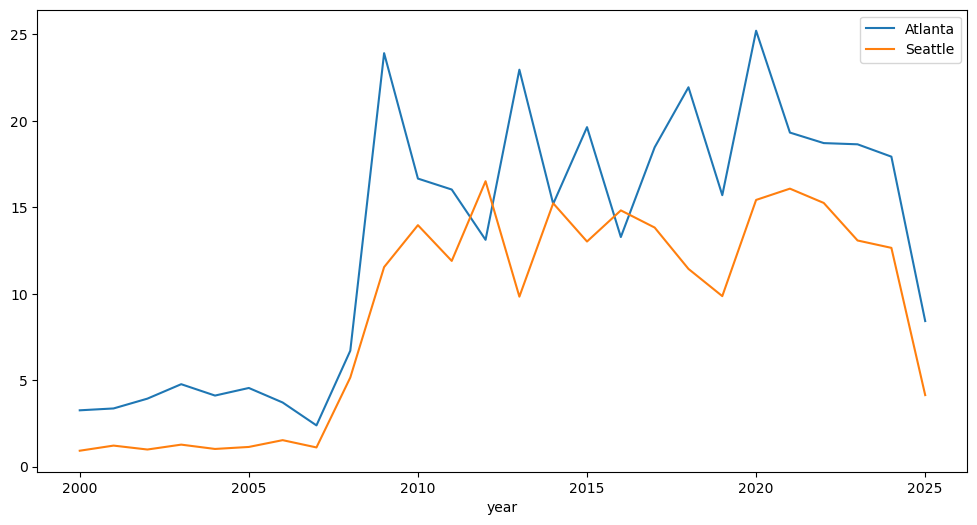

In [32]:
plt.close('all')
plt.rcParams['figure.figsize'] = [12, 6]
fig, ax = subplots()
atlanta_rain.sort_index().to_pandas().plot(ax=ax)
seattle_rain.sort_index().to_pandas().plot(ax=ax)
ax.legend(['Atlanta', 'Seattle'])
plt.show()


### Results

It looks like at least for roughly the last 20 years, it rains more by volume in Atlanta than it does in Seattle.

But as usual the answer raises additional questions:

- Without singling out Atlanta and Seattle, which city actually has the most precipitation by volume?

- Why is there such a large increase in observed precipitation in the last 10 years?

- While it rains more frequently in Seattle (just not as hard), it also mists a lot in Seattle.  How often is it just "misty", but not really raining?
    

In [33]:
client.close()